In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

This is the illustrative example from Bansal et.al. 2000:  https://doi.org/10.1002/aic.690460212

In [2]:
# # Define the inequality functions
# def ineq1(d1, d2):
#     return d1/2 -d2 +1/6
# 
# def ineq2(d1, d2):
#     return -d1/2 + d2/2 + 1
# 
# # Create a mesh grid
# x_vals = np.linspace(0, 5, 400)
# y_vals = np.linspace(0, 5, 400)
# X, Y = np.meshgrid(x_vals, y_vals)
# 
# # Evaluate both inequalities
# Z1 = ineq1(X, Y)
# Z2 = ineq2(X, Y)
# 
# # Create integer mask: 1 if ineq1 ≥ ineq2, 0 otherwise
# region_mask = (Z1 >= Z2).astype(int)
# 
# # Plot the region mask
# plt.figure(figsize=(8, 6))
# contour = plt.contourf(X, Y, region_mask, levels=[-0.5, 0.5, 1.5], colors=['salmon', 'lightblue'], alpha=0.5)
# 
# # Boundary: where ineq1 == ineq2
# plt.contour(X, Y, Z1 - Z2, levels=[0], colors='black', linewidths=2)
# 
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Blue: ineq1 ≥ ineq2, Red: ineq2 > ineq1')
# plt.grid(True)
# plt.axhline(0, color='gray', lw=0.5)
# plt.axvline(0, color='gray', lw=0.5)
# plt.show()


In [3]:
def plot_chi_function(coeff_matrix, var_bounds=None, resolution=400):
    """
    Plot regions where each linear inequality dominates others.

    Parameters:
        coeff_matrix (np.ndarray): m x (n+1) matrix, where each row is [a1, a2, ..., an, b]
                                   representing the inequality: a1*x1 + a2*x2 + ... + an*xn +b <= 0
        var_bounds (list of tuples): [(x1_min, x1_max), (x2_min, x2_max)] bounds for each variable.
                                     Must be length 2 for 2D visualization.
        resolution (int): Grid resolution per axis
    """
    m, cols = coeff_matrix.shape
    n = cols - 1
    assert n == 2, "Currently supports only 2D (x1, x2) visualizations."

    # Handle bounds per variable
    var_bounds = var_bounds if var_bounds else [(-10, 10), (-10, 10)]
    assert len(var_bounds) == 2, "var_bounds must have bounds for exactly 2 variables."

    (x_min, x_max), (y_min, y_max) = var_bounds
    x_vals = np.linspace(x_min, x_max, resolution)
    y_vals = np.linspace(y_min, y_max, resolution)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Compute all inequality lhs - rhs = a1*x1 + a2*x2 - b
    lhs_values = []
    for i in range(m):
        a1, a2, b = coeff_matrix[i]
        lhs = a1 * X + a2 * Y + b
        lhs_values.append(lhs)

    lhs_values = np.array(lhs_values)  # shape: (m, res, res)

    # Determine which inequality dominates at each (x, y)
    dominant_region = np.argmax(lhs_values, axis=0)  # shape: (res, res)

    # Generate distinct random colors
    color_names = list(mcolors.TABLEAU_COLORS) + list(mcolors.CSS4_COLORS)
    random.shuffle(color_names)
    chosen_colors = color_names[:m]

    # Plot regions
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, dominant_region, levels=np.arange(-0.5, m+0.5, 1),
                 colors=chosen_colors, alpha=0.5)

    # Optional: boundary lines
    plt.contour(X, Y, dominant_region, levels=np.arange(-0.5, m), colors='black', linewidths=2)

    # Legend
    for i in range(m):
        plt.plot([], [], color=chosen_colors[i], label=f'Inequality {i+1}')
    plt.legend()

    plt.title('Chi function for flexibility test')
    plt.xlabel('d1')
    plt.ylabel('d2')
    plt.grid(True)
    plt.show()


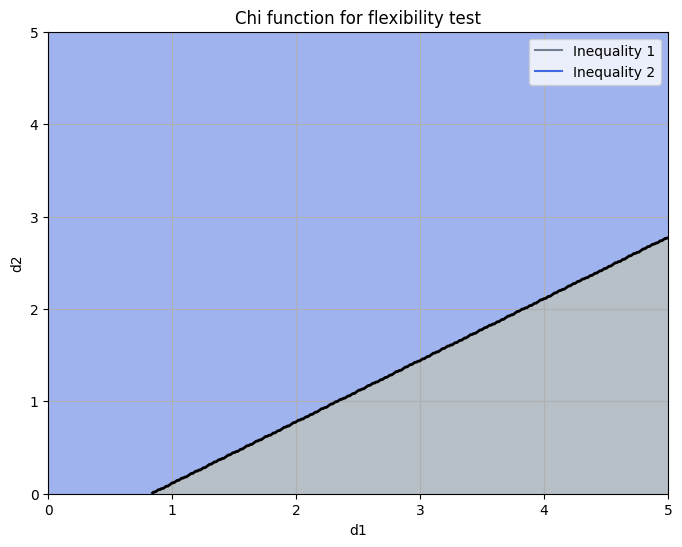

In [4]:
# Each row: [a1, a2, b] → a1*x + a2*y + b <= 0

A = np.array([
    [0.5, -1, 1/6],
    [-0.5, 0.5, 1]
])

plot_chi_function(A, var_bounds=[(0,5), (0,5)])

In [6]:
# # SOMETHING IS INCORRECT HERE
# def evaluate_with_region_constraints(
#     A_main, 
#     A_regions=None, 
#     x_range=(-10, 10), 
#     y_range=(-10, 10), 
#     resolution=400
# ):
#     """
#     Parameters:
#     ----------
#     A_main : np.ndarray, shape (m, 3)
#         Rows represent inequality coefficients: a1*x + a2*y + b <= 0
#     A_regions : list of np.ndarrays, optional
#         Each element is a matrix (k_i, 3) defining the feasible region for inequality i
#     x_range : tuple of (xmin, xmax)
#     y_range : tuple of (ymin, ymax)
#     resolution : int
#         Number of points along each axis for meshgrid
#     """
#     m, n_plus_1 = A_main.shape
#     assert n_plus_1 == 3, "Only 2D case supported (x, y)"
# 
#     # Generate grid
#     x_vals = np.linspace(*x_range, resolution)
#     y_vals = np.linspace(*y_range, resolution)
#     X, Y = np.meshgrid(x_vals, y_vals)
# 
#     dominant_vals = np.full(X.shape, np.nan)
#     dominant_idx = np.full(X.shape, -1)
# 
#     for i in range(m):
#         a1, a2, b = A_main[i]
#         
#         # Default: all points are feasible
#         feasible_mask = np.ones(X.shape, dtype=bool)
# 
#         if A_regions is not None and A_regions[i] is not None:
#             region_constraints = A_regions[i]
#             for constraint in region_constraints:
#                 c1, c2, d = constraint
#                 lhs = c1 * X + c2 * Y + d
#                 feasible_mask &= (lhs <= 0)
# 
#         # Evaluate the main inequality on feasible region
#         lhs_main = a1 * X + a2 * Y + b
#         masked_lhs = np.where(feasible_mask, lhs_main, np.inf)
# 
#         update_mask = (masked_lhs < dominant_vals) | np.isnan(dominant_vals)
#         dominant_vals = np.where(update_mask, masked_lhs, dominant_vals)
#         dominant_idx = np.where(update_mask, i, dominant_idx)
# 
#     # Plotting
#     colors = random.sample(list(mcolors.TABLEAU_COLORS.values()), m)
#     plt.figure(figsize=(8, 6))
#     plt.contourf(X, Y, dominant_idx, levels=np.arange(-0.5, m+0.5), colors=colors, alpha=0.5)
#     plt.contour(X, Y, dominant_idx, levels=np.arange(-0.5, m), colors='black', linewidths=0.5)
# 
#     # Legend
#     for i in range(m):
#         plt.plot([], [], color=colors[i], label=f'Inequality {i+1}')
#     plt.legend()
#     plt.xlabel("x")
#     plt.ylabel("y")
#     plt.title("Dominant Inequality per Region")
#     plt.grid(True)
#     plt.show()


In [7]:
# A_main = np.array([
#     [0.5, -1, 1/6],
#     [-0.5, 0.5, 1]
# ])
# 
# # A_regions = [
# #     np.array([[-2, 3, -1], [-1, 0, 0], [1, 0, 5]]),
# #     np.array([[2, -3, -7], [-1, 0, 0], [0, 1, -5]])
# # ]
# 
# evaluate_with_region_constraints(A_main=A_main, A_regions=A_regions, x_range=(0,5), y_range=(0,5))

In [8]:
def plot_flexibility_function(coeff_matrix, var_bounds=None, resolution=400):
    """
    Plot regions where each linear inequality dominates others.

    Parameters:
        coeff_matrix (np.ndarray): m x (n+1) matrix, where each row is [a1, a2, ..., an, b]
                                   representing the inequality: a1*x1 + a2*x2 + ... + an*xn +b <= 0
        var_bounds (list of tuples): [(x1_min, x1_max), (x2_min, x2_max)] bounds for each variable.
                                     Must be length 2 for 2D visualization.
        resolution (int): Grid resolution per axis
    """
    m, cols = coeff_matrix.shape
    n = cols - 1
    assert n == 2, "Currently supports only 2D (x1, x2) visualizations."

    # Handle bounds per variable
    var_bounds = var_bounds if var_bounds else [(-10, 10), (-10, 10)]
    assert len(var_bounds) == 2, "var_bounds must have bounds for exactly 2 variables."

    (x_min, x_max), (y_min, y_max) = var_bounds
    x_vals = np.linspace(x_min, x_max, resolution)
    y_vals = np.linspace(y_min, y_max, resolution)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Compute all inequality lhs - rhs = a1*x1 + a2*x2 - b
    lhs_values = []
    for i in range(m):
        a1, a2, b = coeff_matrix[i]
        lhs = -a1 * X - a2 * Y - b+1
        lhs_values.append(lhs)

    lhs_values = np.array(lhs_values)  # shape: (m, res, res)

    # Determine which inequality dominates at each (x, y)
    dominant_region = np.argmin(lhs_values, axis=0)  # shape: (res, res)

    # Generate distinct random colors
    color_names = list(mcolors.TABLEAU_COLORS) + list(mcolors.CSS4_COLORS)
    random.shuffle(color_names)
    chosen_colors = color_names[:m]
    
    # Generate separate colors for violated regions
    violation_palette = list(mcolors.XKCD_COLORS)
    random.shuffle(violation_palette)
    violation_colors = [violation_palette[i] for i in range(m)]


    # Plot regions
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, dominant_region, levels=np.arange(-0.5, m+0.5, 1),
                 colors=chosen_colors, alpha=0.5)

    # Optional: boundary lines
    plt.contour(X, Y, dominant_region, levels=np.arange(-0.5, m), colors='black', linewidths=2)
    
    for i in range(m):
        a1, a2, b = coeff_matrix[i]
        violation_mask = (a1 * X + a2 * Y + b) >= 0
        plt.contourf(X, Y, violation_mask.astype(int), levels=[0.5, 1.5],
                     colors=[violation_colors[i]], alpha=0.25)
        plt.contour(X, Y, a1 * X + a2 * Y + b, levels=[0], colors='black')

    # Legend
    for i in range(m):
        plt.plot([], [], color=chosen_colors[i], label=f'Inequality {i+1}')
    plt.legend()

    plt.title('Flexibility index function')
    plt.xlabel('d1')
    plt.ylabel('d2')
    plt.grid(True)
    plt.show()


In [9]:
A = np.array([
    [-3/11, 6/11, 10/11],
    [3/16, -3/16, 10/16],
])

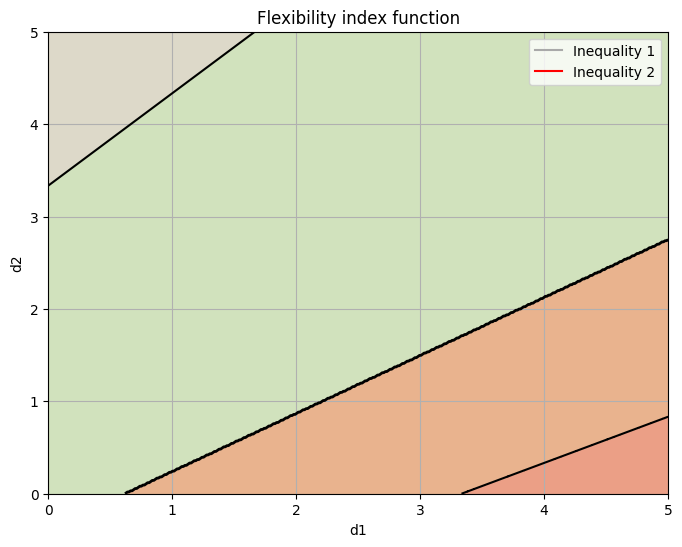

In [10]:
plot_flexibility_function(coeff_matrix=A, var_bounds=[(0,5), (0,5)])